# 使用GaborNet模型訓練Dogs vs. Cats資料集
資料集網站：https://www.kaggle.com/c/dogs-vs-cats

程式參考網站：https://www.kaggle.com/reukki/pytorch-cnn-tutorial-with-cats-and-dogs

# 查看 Google Colab GPU
GPU種類：NVIDIA Tesla K80、P4、T4、P100 和 V100

In [1]:
! /opt/bin/nvidia-smi

Thu Jul 29 09:57:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 防止Googole Colab斷線
每60分鐘自動執行程式碼刷新

使用方法：colab頁面按下F12 或 Ctrl+Shift+I (MAC按 Option+Command+I) 在console（控制台）輸入以下程式碼

複製以下程式碼貼在瀏覽器console！！不要關閉瀏覽器以免失效

In [ ]:
"""
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);
"""

# 取得資料夾


In [5]:
!pwd

/content/gdrive/MyDrive/ML/GaborNet/sanity_check


In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
%cd gdrive/MyDrive/ML/GaborNet/sanity_check

/content/gdrive/MyDrive/ML/GaborNet/sanity_check


# 安裝套件

In [6]:
!pip install torchinfo
!pip install gabornet

     |████████████████████████████████| 5.9 MB 6.9 MB/s 
     |████████████████████████████████| 748.8 MB 16 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.6.0 which is incompatible.


In [7]:
import json
import os
import time
from typing import Any

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import yaml
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torchinfo import summary
from PIL import Image
from matplotlib import pyplot as plt
from GaborNet import GaborConv2d
from dataset import DogsCatsDataset

In [9]:
#設定固定初始化種子，確保每次得到同樣測試結果
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)
print(device)

cuda


# 準備資料和資料預處理


In [12]:
train_dir = '../data/train'
test_dir = '../data/val'

train_set = os.listdir(train_dir)
test_set = os.listdir(test_dir)


In [13]:
print(len(train_set))
print(len(test_set))

25000
12500


In [14]:
import glob

train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

In [15]:
print(len(train_list), len(test_list))

25000 12500


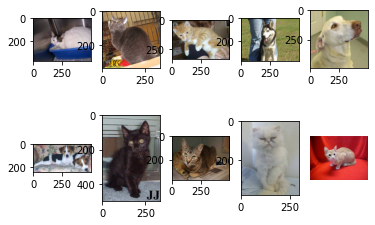

In [16]:
from PIL import Image
random_idx = np.random.randint(1,25000,size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(train_list[idx])
    plt.imshow(img)
    i+=1

plt.axis('off')
plt.show()

In [17]:
int(test_list[0].split('/')[-1].split('.')[0])

11497

In [18]:
from sklearn.model_selection import train_test_split
train_list, val_list = train_test_split(train_list, test_size=0.3)

In [19]:
print(len(train_list), len(test_list))

17500 12500


In [20]:
train_transforms =  transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])


test_transforms = transforms.Compose([   
    transforms.Resize((256, 256)),
     transforms.RandomResizedCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])

# 建立資料集

In [21]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
        
    #dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    #load an one of images
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label=1
        elif label == 'cat':
            label=0
            
        return img_transformed,label

# 載入資料集

In [22]:
train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=test_transforms)

In [23]:
train_loader = DataLoader(dataset = train_data, batch_size=64, shuffle=True )
test_loader = DataLoader(dataset = test_data, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset = val_data, batch_size=64, shuffle=True)

In [24]:
print(len(train_data), len(train_loader))

17500 274


In [25]:
print(len(val_data), len(val_loader))

7500 118


In [26]:
train_data[0][0].shape

torch.Size([3, 256, 256])

# 建立訓練模型

In [27]:
class GaborNN(nn.Module):

    def __init__(self):
        super(GaborNN, self).__init__()
        self.g1 = GaborConv2d(3, 32, kernel_size=(15, 15), stride=1)
        self.c1 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1)
        self.c2 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=1)
        self.c3 = nn.Conv2d(128, 128, kernel_size=(3, 3), stride=1)
        self.c4 = nn.Conv2d(128, 128, kernel_size=(3, 3), stride=1)
        self.fc1 = nn.Linear(3200, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.g1(x)), kernel_size=2)
        x = nn.Dropout2d()(x)
        x = F.max_pool2d(F.relu(self.c1(x)), kernel_size=2)
        x = F.max_pool2d(F.relu(self.c2(x)), kernel_size=2)
        x = F.max_pool2d(F.relu(self.c3(x)), kernel_size=2)
        x = F.max_pool2d(F.relu(self.c4(x)), kernel_size=2)
        x = nn.Dropout2d()(x)
        x = x.view(-1, 3200)
        x = F.relu(self.fc1(x))
        x = nn.Dropout2d()(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

# 訓練模型

In [28]:
model = GaborNN().to(device)
model.train()

GaborNN(
  (g1): GaborConv2d(
    (conv_layer): Conv2d(3, 32, kernel_size=(15, 15), stride=(1, 1), bias=False)
  )
  (c1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (c2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (c3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (c4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)

In [29]:
summary(model, (100 , 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
GaborNN                                  --                        --
├─GaborConv2d: 1-1                       [100, 32, 242, 242]       --
│    └─Conv2d: 2-1                       [100, 32, 242, 242]       21,600
├─Conv2d: 1-2                            [100, 64, 119, 119]       18,496
├─Conv2d: 1-3                            [100, 128, 57, 57]        73,856
├─Conv2d: 1-4                            [100, 128, 26, 26]        147,584
├─Conv2d: 1-5                            [100, 128, 11, 11]        147,584
├─Linear: 1-6                            [100, 128]                409,728
├─Linear: 1-7                            [100, 128]                16,512
├─Linear: 1-8                            [100, 2]                  258
Total params: 835,618
Trainable params: 835,618
Non-trainable params: 0
Total mult-adds (G): 188.49
Input size (MB): 78.64
Forward/backward pass size (MB): 2638.80
Params size (MB): 3.34
Estima

In [30]:
optimizer = optim.Adam(params = model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

In [31]:
epochs = 40

acc_list = []
loss_list = []
val_acc_list = []
val_loss_list = []



for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    
    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)
        
        output = model(data)
        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)
        
    print('Epoch : {}, train accuracy : {:.4f}, train loss : {:.4f}'.format(epoch+1, epoch_accuracy,epoch_loss))
    acc_list.append(float(epoch_accuracy))
    loss_list.append(float(epoch_loss))
    
    
    with torch.no_grad():
        epoch_val_accuracy=0
        epoch_val_loss =0
        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)
            
            val_output = model(data)
            val_loss = criterion(val_output,label)
            
            
            acc = ((val_output.argmax(dim=1) == label).float().mean())
            epoch_val_accuracy += acc/ len(val_loader)
            epoch_val_loss += val_loss/ len(val_loader)
            
        print('Epoch : {}, val_accuracy : {:.4f}, val_loss : {:.4f}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))
        val_acc_list.append(float(epoch_val_accuracy))
        val_loss_list.append(float(epoch_val_loss))

Epoch : 1, train accuracy : 0.5113, train loss : 0.6927
Epoch : 1, val_accuracy : 0.5388, val_loss : 0.6940
Epoch : 2, train accuracy : 0.5625, train loss : 0.6847
Epoch : 2, val_accuracy : 0.5723, val_loss : 0.6823
Epoch : 3, train accuracy : 0.5862, train loss : 0.6763
Epoch : 3, val_accuracy : 0.6060, val_loss : 0.6642
Epoch : 4, train accuracy : 0.6079, train loss : 0.6652
Epoch : 4, val_accuracy : 0.6187, val_loss : 0.6561
Epoch : 5, train accuracy : 0.6182, train loss : 0.6566
Epoch : 5, val_accuracy : 0.6116, val_loss : 0.6606
Epoch : 6, train accuracy : 0.6250, train loss : 0.6503
Epoch : 6, val_accuracy : 0.6374, val_loss : 0.6441
Epoch : 7, train accuracy : 0.6335, train loss : 0.6433
Epoch : 7, val_accuracy : 0.6393, val_loss : 0.6496
Epoch : 8, train accuracy : 0.6428, train loss : 0.6344
Epoch : 8, val_accuracy : 0.6396, val_loss : 0.6357
Epoch : 9, train accuracy : 0.6534, train loss : 0.6261
Epoch : 9, val_accuracy : 0.6378, val_loss : 0.6405
Epoch : 10, train accuracy :

# 訓練結果圖

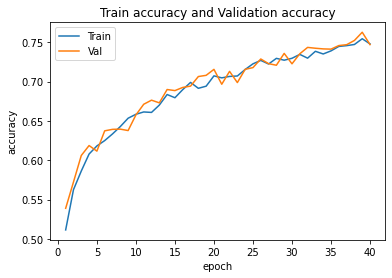

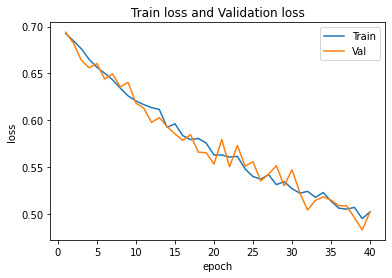

In [36]:
import matplotlib.pyplot as plt

xpt = []
x = 0
for i in range(40):
  x+=1
  xpt.append(x)

plt.title('Train accuracy and Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
Data_1, = plt.plot(xpt, acc_list, label ='Train')
Data_2, = plt.plot(xpt, val_acc_list, label ="Val")
plt.legend()
plt.show()


plt.title('Train loss and Validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
Data_1, = plt.plot(xpt, loss_list, label ='Train')
Data_2, = plt.plot(xpt, val_loss_list, label ="Val")
plt.legend()
plt.show()




# 查看模型預測能力(還在測試)

In [40]:
dog_probs = []
model.eval()
with torch.no_grad():
    for data, fileid in test_loader:
        data = data.to(device)
        preds = model(data)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        dog_probs += list(zip(list(fileid), preds_list))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-40-1ba3f36db5ba>", line 4, in <module>
    for data, fileid in test_loader:
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 363, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 403, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-21-96f7c8e08612>", line 15, in __getitem_

OSError: ignored

In [42]:
dog_probs.sort(key = lambda x : int(x[0]))
dog_probs

[]

In [43]:
idx = list(map(lambda x: x[0],dog_probs))
prob = list(map(lambda x: x[1],dog_probs))

In [44]:
submission = pd.DataFrame({'id':idx,'label':prob})

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-44-10ae6955e7ae>", line 1, in <module>
    submission = pd.DataFrame({'id':idx,'label':prob})
NameError: name 'pd' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.7/dist-packages/

NameError: ignored

In [45]:
submission.to_csv('result.csv',index=False)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-45-70ab853bc090>", line 1, in <module>
    submission.to_csv('result.csv',index=False)
NameError: name 'submission' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.7/dist-packages

NameError: ignored

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-46-8c43eab12f56>", line 10, in <module>
    i = random.choice(submission['id'].values)
NameError: name 'submission' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.7/dist-packages

NameError: ignored

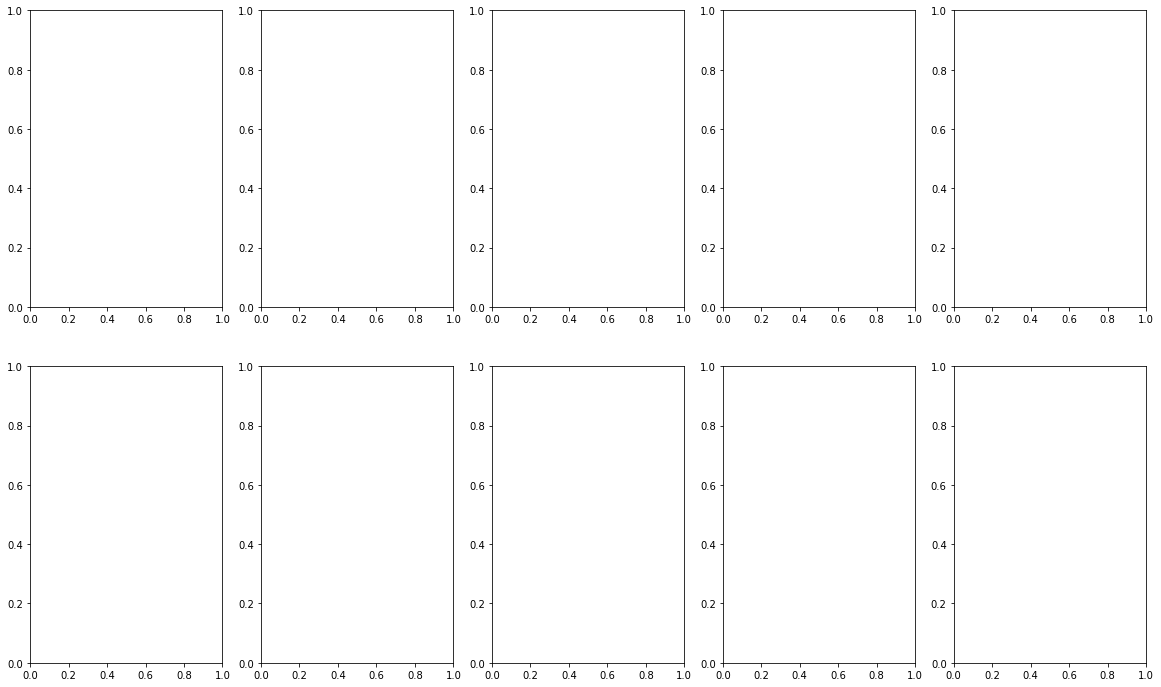

In [46]:
import random

id_list = []
class_ = {0: 'cat', 1: 'dog'}

fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    
    i = random.choice(submission['id'].values)
    
    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = os.path.join(test_dir, '{}.jpg'.format(i))
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)